In [27]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [28]:
df = pd.read_csv("../output/2324_growth.csv")
df['plot'] = ((df['ID'] - 1) // 10) + 1
df['year'] = '20' + (df['date'].astype(str).str[0:2])
df['year'] = df['year'].astype(int)
df['초장(cm)'] = df.apply(lambda row: row['간장(cm)'] + row['수장(cm)'] if pd.isna(row['초장(cm)'])else row['초장(cm)'], axis=1)
df['생육단계_숫자'] = pd.Categorical(df['생육단계'], categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'], ordered=True).codes

In [29]:
df['year-plot'] = df['year'].astype(str) + '-' + df['plot'].astype(str)

In [30]:
df['파종'] = df['plot'].apply(lambda x: '광산' if x <= 4 else '세조')
df['시비'] = df['plot'].apply(lambda x: '추비' if x in [2, 3, 6,7 ] else '기비')
df['파종_시비'] = df['파종'] + '_' + df['시비']
df

,ID,생육단계,LAI,SPAD,유수길이(mm),초장(cm),1수영화수,간장(cm),경수(20*20cm2),수장(cm),...,GNDVI,RVI,CVI,plot,year,생육단계_숫자,year-plot,파종,시비,파종_시비
0,1,분얼전기,0.07,37.6,1.5,20.0,NaN,NaN,NaN,NaN,...,0.495609,2.557755,0.378150,1,2023,0,2023-1,광산,기비,광산_기비
1,2,분얼전기,0.07,38.1,1.2,22.0,NaN,NaN,NaN,NaN,...,0.359478,1.438161,0.391021,1,2023,0,2023-1,광산,기비,광산_기비
2,3,분얼전기,0.07,38.7,1.5,18.0,NaN,NaN,NaN,NaN,...,0.356621,1.450934,0.395626,1,2023,0,2023-1,광산,기비,광산_기비
3,4,분얼전기,0.08,39.2,1.0,18.5,NaN,NaN,NaN,NaN,...,0.399532,1.631073,0.388953,1,2023,0,2023-1,광산,기비,광산_기비
4,5,분얼전기,0.08,39.7,0.7,19.5,NaN,NaN,NaN,NaN,...,0.390062,1.647158,0.441491,1,2023,0,2023-1,광산,기비,광산_기비
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,76,수확기,1.12,10.2,NaN,67.0,NaN,59.0,48.0,8.0,...,0.478998,1.476466,0.055060,8,2024,5,2024-8,세조,기비,세조_기비
956,77,수확기,1.04,10.5,NaN,63.5,NaN,56.0,NaN,7.5,...,0.500372,1.567627,0.058452,8,2024,5,2024-8,세조,기비,세조_기비
957,78,수확기,1.07,9.4,NaN,63.5,NaN,56.0,NaN,7.5,...,0.488268,1.501483,0.056885,8,2024,5,2024-8,세조,기비,세조_기비
958,79,수확기,0.93,11.9,NaN,68.0,NaN,60.0,NaN,8.0,...,0.489779,1.551465,0.055377,8,2024,5,2024-8,세조,기비,세조_기비


In [4]:
def polynomial_regression(df, x, y, degree):
    df = df[[x, y]].dropna()
    x_features = []
    y_features = []
    
    x_features.extend(df[x])
    y_features.extend(df[y])
    
    x_real = np.reshape(x_features, (-1, 1))
    y_real = np.reshape(y_features, (-1, 1))
    
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = polynomial_features.fit_transform(x_real)
    
    model = LinearRegression()
    model.fit(x_poly, y_real)
    
    return model.intercept_[0], model.coef_[0][0], model.coef_[0][1], model.coef_[0][2]

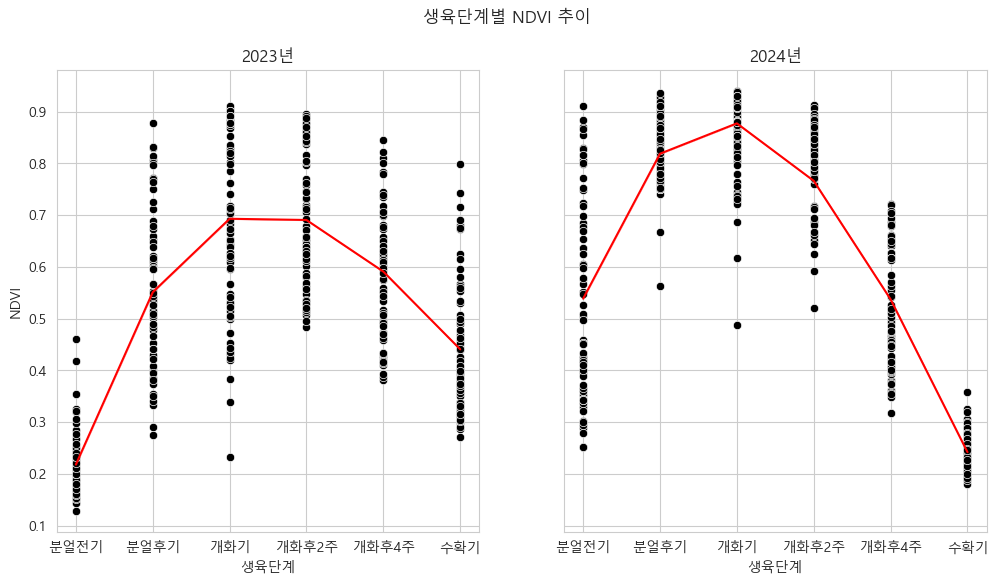

In [5]:
y_feature_name = 'NDVI'
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for i, year in enumerate([2023, 2024]):
    ax = axes[i]
    df_target = df[df['year'] == year]
    poly_values = polynomial_regression(df_target, '생육단계_숫자', y_feature_name, 3)
    poly_series = df_target['생육단계_숫자'].apply(lambda x: x * poly_values[1] + x ** 2 * poly_values[2] + x ** 3 * poly_values[3] + poly_values[0])
    sns.scatterplot(x='생육단계', y=y_feature_name, data=df_target, color='black', ax=ax);
    sns.lineplot(x='생육단계', y=poly_series, data=df_target, color='red', ax=ax);
    ax.set_title(f'{year}년')

fig.suptitle(f'생육단계별 {y_feature_name} 추이');

In [31]:
y_variables = ['초장(cm)', 'LAI', 'SPAD', 'NDVI', 'GNDVI', 'RVI', 'CVI', 'NDRE'] 

df_mean = df.groupby(['year-plot', '생육단계'])[y_variables].mean().reset_index()
df_mean['year'] = df_mean['year-plot'].str.split('-').str[0].astype(int)
df_mean['plot'] = df_mean['year-plot'].str.split('-').str[1]
from pandas.api.types import CategoricalDtype
df_mean['생육단계'] = df_mean['생육단계'].astype(CategoricalDtype(categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'], ordered=True))

In [32]:
df_year = df.groupby(['year', '생육단계'])[y_variables].mean().reset_index()
from pandas.api.types import CategoricalDtype
df_year['생육단계'] = df_year['생육단계'].astype(CategoricalDtype(categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'], ordered=True))
df_year

,year,생육단계,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
0,2023,개화기,62.92500,1.013250,49.57375,0.677952,0.709164,7.987663,0.150838,0.342640
1,2023,개화후2주,70.20000,1.434875,47.72875,0.708290,0.718113,7.838082,0.138867,0.348869
2,2023,개화후4주,63.64750,0.391375,26.47875,0.580687,0.658032,4.428632,0.087701,0.207766
3,2023,분얼전기,20.03500,0.123750,38.78750,0.217282,0.393544,1.594860,0.450301,0.099096
4,2023,분얼후기,40.99375,1.060875,45.61000,0.557156,0.597753,4.559470,0.095124,0.253745
5,2023,수확기,60.01875,0.645556,10.95625,0.443133,0.549392,3.644012,0.156195,0.203376
6,2024,개화기,80.58750,2.756750,43.10500,0.843837,0.775461,15.188799,0.053287,0.469109
7,2024,개화후2주,73.26875,2.255875,38.82925,0.803511,0.740867,10.780494,0.049668,0.403675
8,2024,개화후4주,74.95625,1.226625,21.12875,0.516695,0.623598,3.448130,0.059167,0.200423
9,2024,분얼전기,19.37500,0.543875,35.31000,0.536084,0.502567,4.963023,0.026712,0.231562


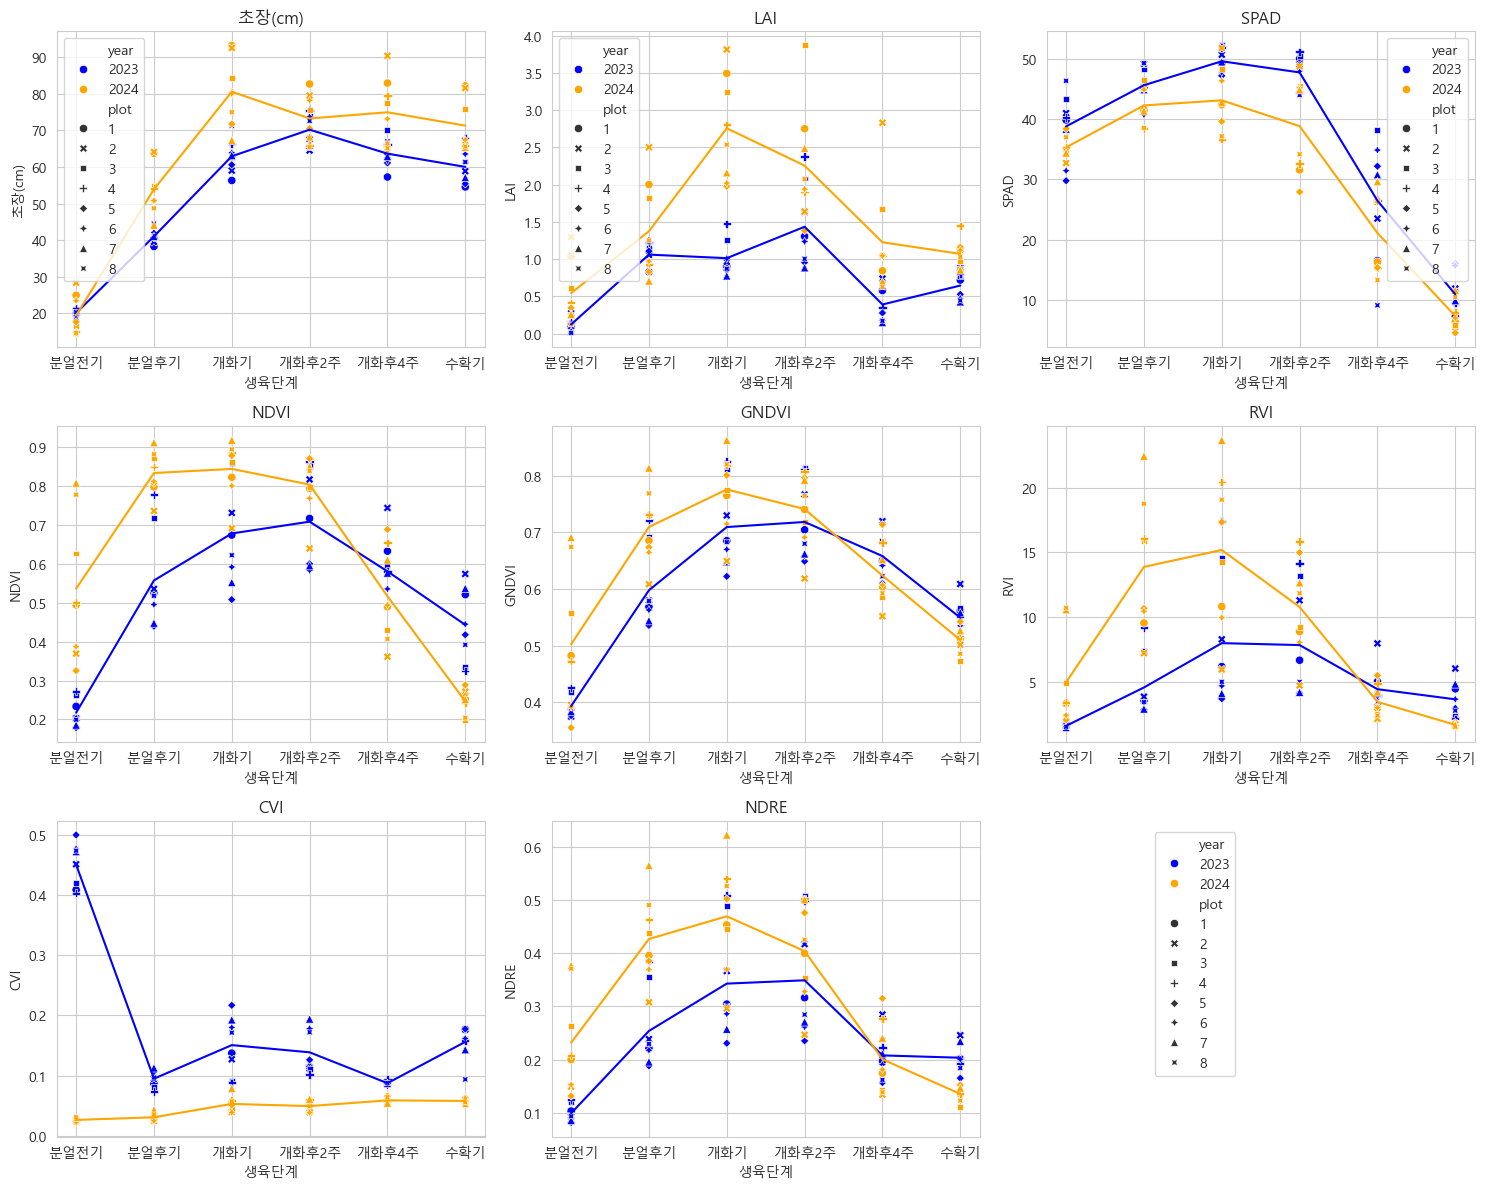

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 서브플롯 (마지막은 빈 칸)
palette = {2023: 'blue', 2024: 'orange'}

# 첫 번째 행: 첫 3개의 y값
for i, y in enumerate(y_variables[:3]):
    sns.scatterplot(x='생육단계', y=y, style='plot', hue='year', data=df_mean, ax=axes[0, i], palette=palette, legend='brief')
    sns.lineplot(x='생육단계', y=y, hue='year', data=df_year, ax=axes[0, i], palette=palette, legend=False)
    axes[0, i].set_title(y)

# 두 번째 행: 중간 3개의 y값
for i, y in enumerate(y_variables[3:6]):
    sns.scatterplot(x='생육단계', y=y, style='plot', hue='year', data=df_mean, ax=axes[1, i], palette=palette, legend=False)
    sns.lineplot(x='생육단계', y=y, hue='year', data=df_year, ax=axes[1, i], palette=palette, legend=False)
    axes[1, i].set_title(y)

# 세 번째 행: 마지막 2개의 y값
for i, y in enumerate(y_variables[6:]):
    sns.scatterplot(x='생육단계', y=y, style='plot', hue='year', data=df_mean, ax=axes[2, i], palette=palette, legend=False)
    sns.lineplot(x='생육단계', y=y, hue='year', data=df_year, ax=axes[2, i], palette=palette, legend=False)
    axes[2, i].set_title(y)

# 빈 서브플롯에 범례 추가
axes[2, 2].axis('off')  # 빈 서브플롯 숨기기
handles, labels = axes[0, 0].get_legend_handles_labels()  # 범례 핸들과 레이블 가져오기
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.8,0.2), ncol=1)

plt.tight_layout()
plt.show()


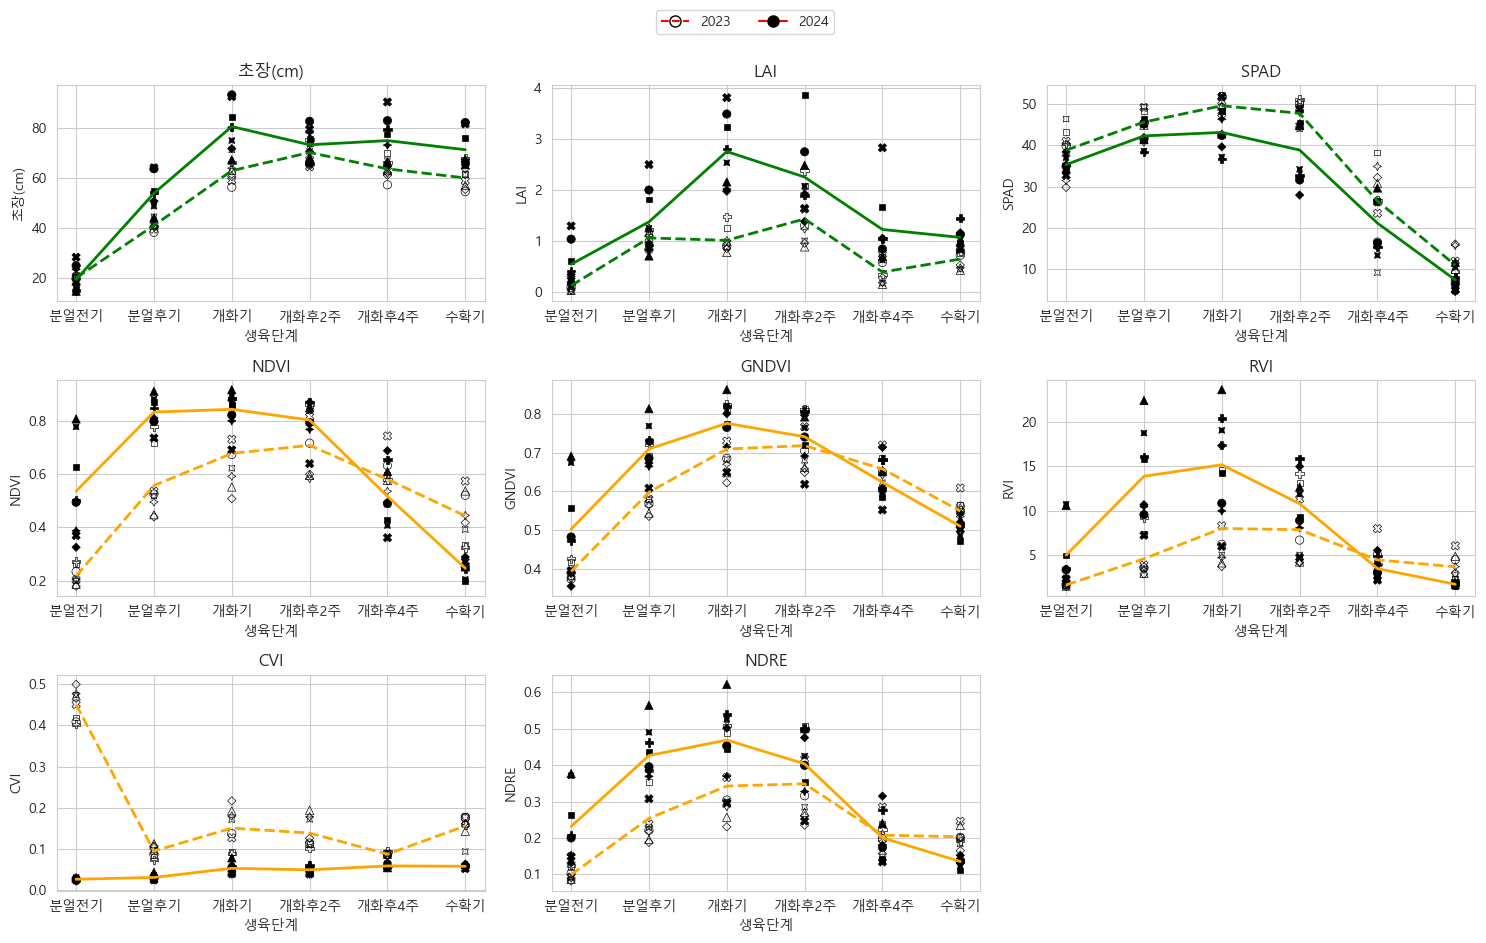

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(15, 9))  # 3x3 서브플롯 (마지막은 빈 칸)

# 마커 스타일 설정
marker_styles = {2023: 'o', 2024: 'o'}  # 마커 모양
line_styles = {2023: '--', 2024: '-'}  # 선 스타일

# 첫 번째 행: 첫 3개의 y값
for i, y in enumerate(y_variables[:3]):
    for year in [2023, 2024]:
        data_subset = df_mean[df_mean['year'] == year]
        sns.scatterplot(
            x='생육단계',
            y=y,
            data=data_subset,
            ax=axes[0, i],
            style='plot',
            markers=True,
            color='black',
            edgecolor='black',
            legend=False,
            facecolors='none' if year == 2023 else 'black',  # 2023 비우기, 2024 채우기
        )
        sns.lineplot(
            x='생육단계',
            y=y,
            data=df_year[df_year['year'] == year],
            ax=axes[0, i],
            color='green',
            linestyle=line_styles[year],
            linewidth=2
        )
    axes[0, i].set_title(y)

# 두 번째 행: 중간 3개의 y값
for i, y in enumerate(y_variables[3:6]):
    for year in [2023, 2024]:
        data_subset = df_mean[df_mean['year'] == year]
        sns.scatterplot(
            x='생육단계',
            y=y,
            data=data_subset,
            ax=axes[1, i],
            style='plot',
            markers=True,
            color='black',
            edgecolor='black',
            legend=False,
            facecolors='none' if year == 2023 else 'black',
        )
        sns.lineplot(
            x='생육단계',
            y=y,
            data=df_year[df_year['year'] == year],
            ax=axes[1, i],
            color='orange',
            linestyle=line_styles[year],
            linewidth=2
        )
    axes[1, i].set_title(y)

# 세 번째 행: 마지막 2개의 y값
for i, y in enumerate(y_variables[6:]):
    for year in [2023, 2024]:
        data_subset = df_mean[df_mean['year'] == year]
        sns.scatterplot(
            x='생육단계',
            y=y,
            data=data_subset,
            ax=axes[2, i],
            style='plot',
            markers=True,
            color='black',
            edgecolor='black',
            legend=False,
            facecolors='none' if year == 2023 else 'black',
        )
        sns.lineplot(
            x='생육단계',
            y=y,
            data=df_year[df_year['year'] == year],
            ax=axes[2, i],
            color='orange',
            linestyle=line_styles[year],
            linewidth=2
        )
    axes[2, i].set_title(y)

# 빈 서브플롯에 범례 추가
axes[2, 2].axis('off')
fig.legend(
    handles=[
        plt.Line2D([0], [0], color='red', linestyle='--', marker='o', markersize=8, markerfacecolor='none', markeredgecolor='black', label='2023'),
        plt.Line2D([0], [0], color='red', linestyle='-', marker='o', markersize=8, markerfacecolor='black', markeredgecolor='black', label='2024')
    ],
    loc='upper center',  # 상단에 위치
    bbox_to_anchor=(0.5, 1.05),  # 범례 위치 조정
    ncol=2  # 범례를 가로로 배열
)

plt.tight_layout()
plt.savefig('../output/timeseries.png')


In [146]:
for i, y in enumerate(y_variables[6:]):
    sns.scatterplot(x='생육단계', y=y, hue='year-plot', data=df_mean, ax=axes[2, i], legend=False)
    axes[2, i].set_title(y)

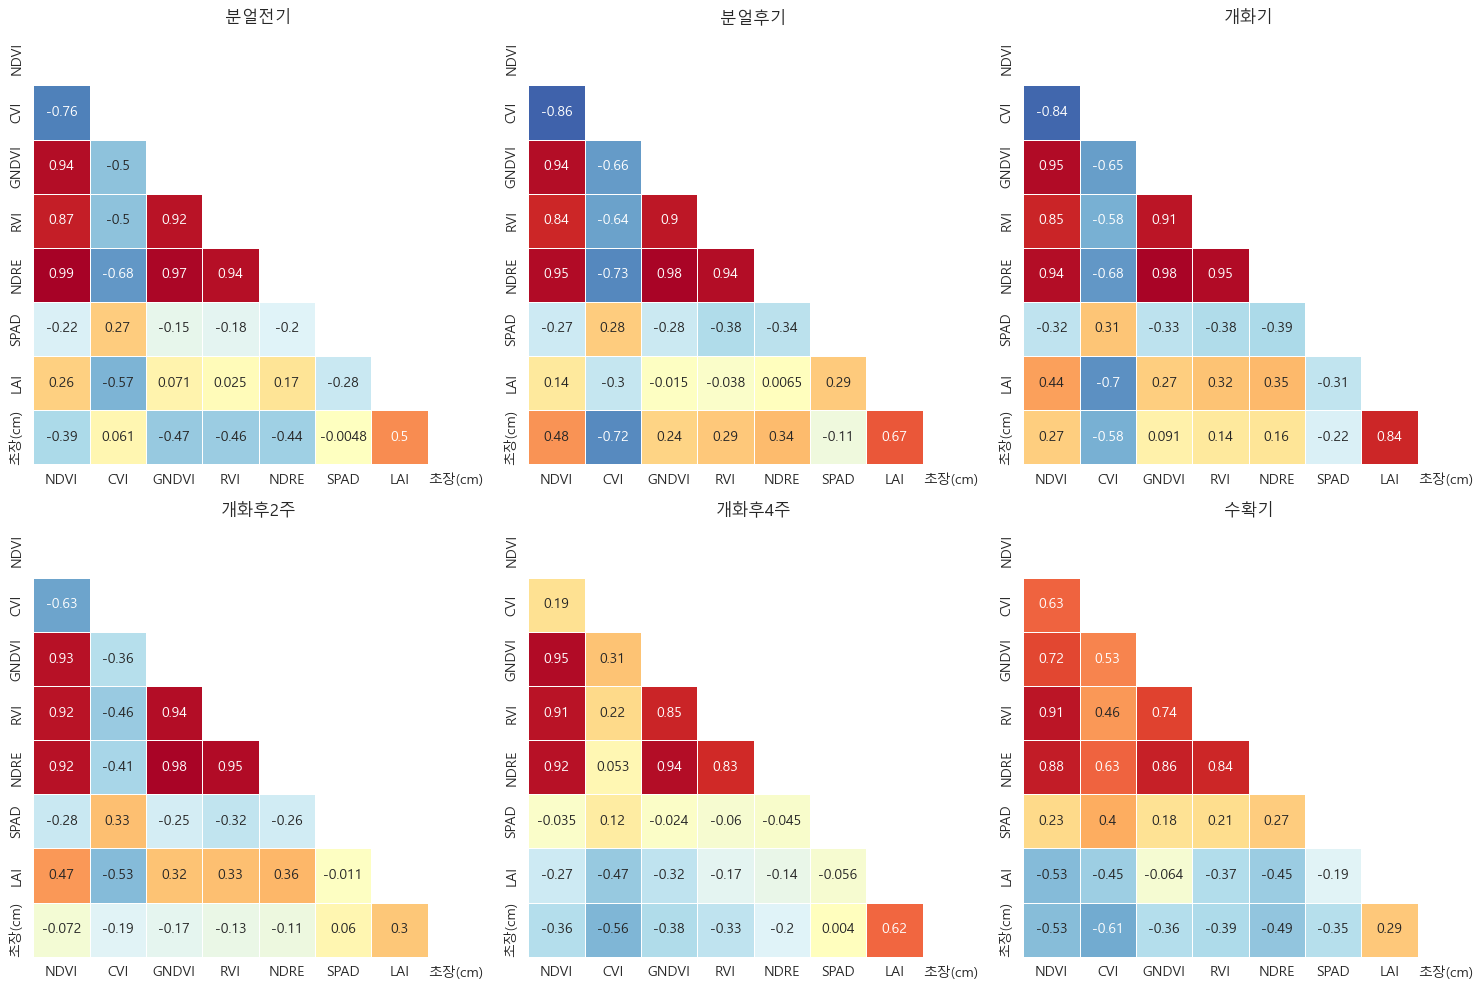

In [148]:
def draw_corr(stage, df, ax):
    df_stage = df[df['생육단계'] == stage]
    df_stage = df_stage.dropna(axis=1, how='all')
    # cols = [col for col in df_stage.columns if col not in ['ID', 'date', 'plot', 'year', '생육단계', '생육단계_숫자']]
    # cols.reverse()
    cols = ['NDVI', 'CVI', 'GNDVI', 'RVI', 'NDRE', 'SPAD', 'LAI', '초장(cm)']
    df_corr = df_stage[cols].corr()
    
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    sns.heatmap(df_corr, 
                cmap = 'RdYlBu_r', 
                annot = True,
                mask=mask, 
                linewidths=.5,
                cbar_kws={"shrink": .5},
                vmin = -1,vmax = 1,
                ax=ax, cbar=False
               )    
    ax.set_title(stage)
    ax.grid(False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# for year in [2023, 2024]:
# year = 2024
for i, stage in enumerate(['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기']):
    # df_year = df[df['year'] == year]
    # draw_corr(stage, df_year, axes[i])
    draw_corr(stage, df, axes[i])
plt.tight_layout()
plt.show()

In [149]:
# def draw_corr(stage, df_corr):
#     # fig, ax = plt.subplots( figsize=(7,7) )
#     
#     mask = np.zeros_like(df_corr, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True
#     
#     sns.heatmap(df_corr, 
#                 cmap = 'RdYlBu_r', 
#                 annot = True,
#                 mask=mask, 
#                 linewidths=.5,
#                 cbar_kws={"shrink": .5},
#                 vmin = -1,vmax = 1
#                )
#     plt.title(f"{stage} 변수 상관관계")
#     plt.grid(False)
#     plt.show()
# for stage in ['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기']:
    # df_stage = df[df['생육단계'] == stage]
    # df_stage = df_stage.dropna(axis=1, how='all')
    # cols = [col for col in df_stage.columns if col not in ['ID', 'date', 'plot', 'year', '생육단계', '생육단계_숫자']]
    # cols.reverse()
    # df_corr = df_stage[cols].corr()
    
    # draw_corr(stage, df_corr)

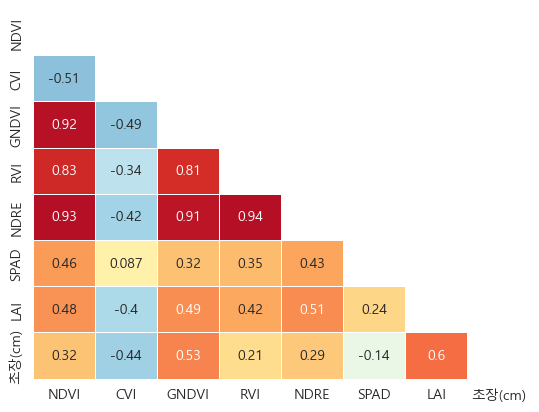

In [150]:
# df = df[df['year'] == 2024]
df = df.dropna(axis=1, how='all')
# cols = [col for col in df_stage.columns if col not in ['ID', 'date', 'plot', 'year', '생육단계', '생육단계_숫자']]
# cols.reverse()
cols = ['NDVI', 'CVI', 'GNDVI', 'RVI', 'NDRE', 'SPAD', 'LAI', '초장(cm)']
df_corr = df[cols].corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr, 
            cmap = 'RdYlBu_r', 
            annot = True,
            mask=mask, 
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1,
            cbar=False
           )    

plt.grid(False)
plt.show()

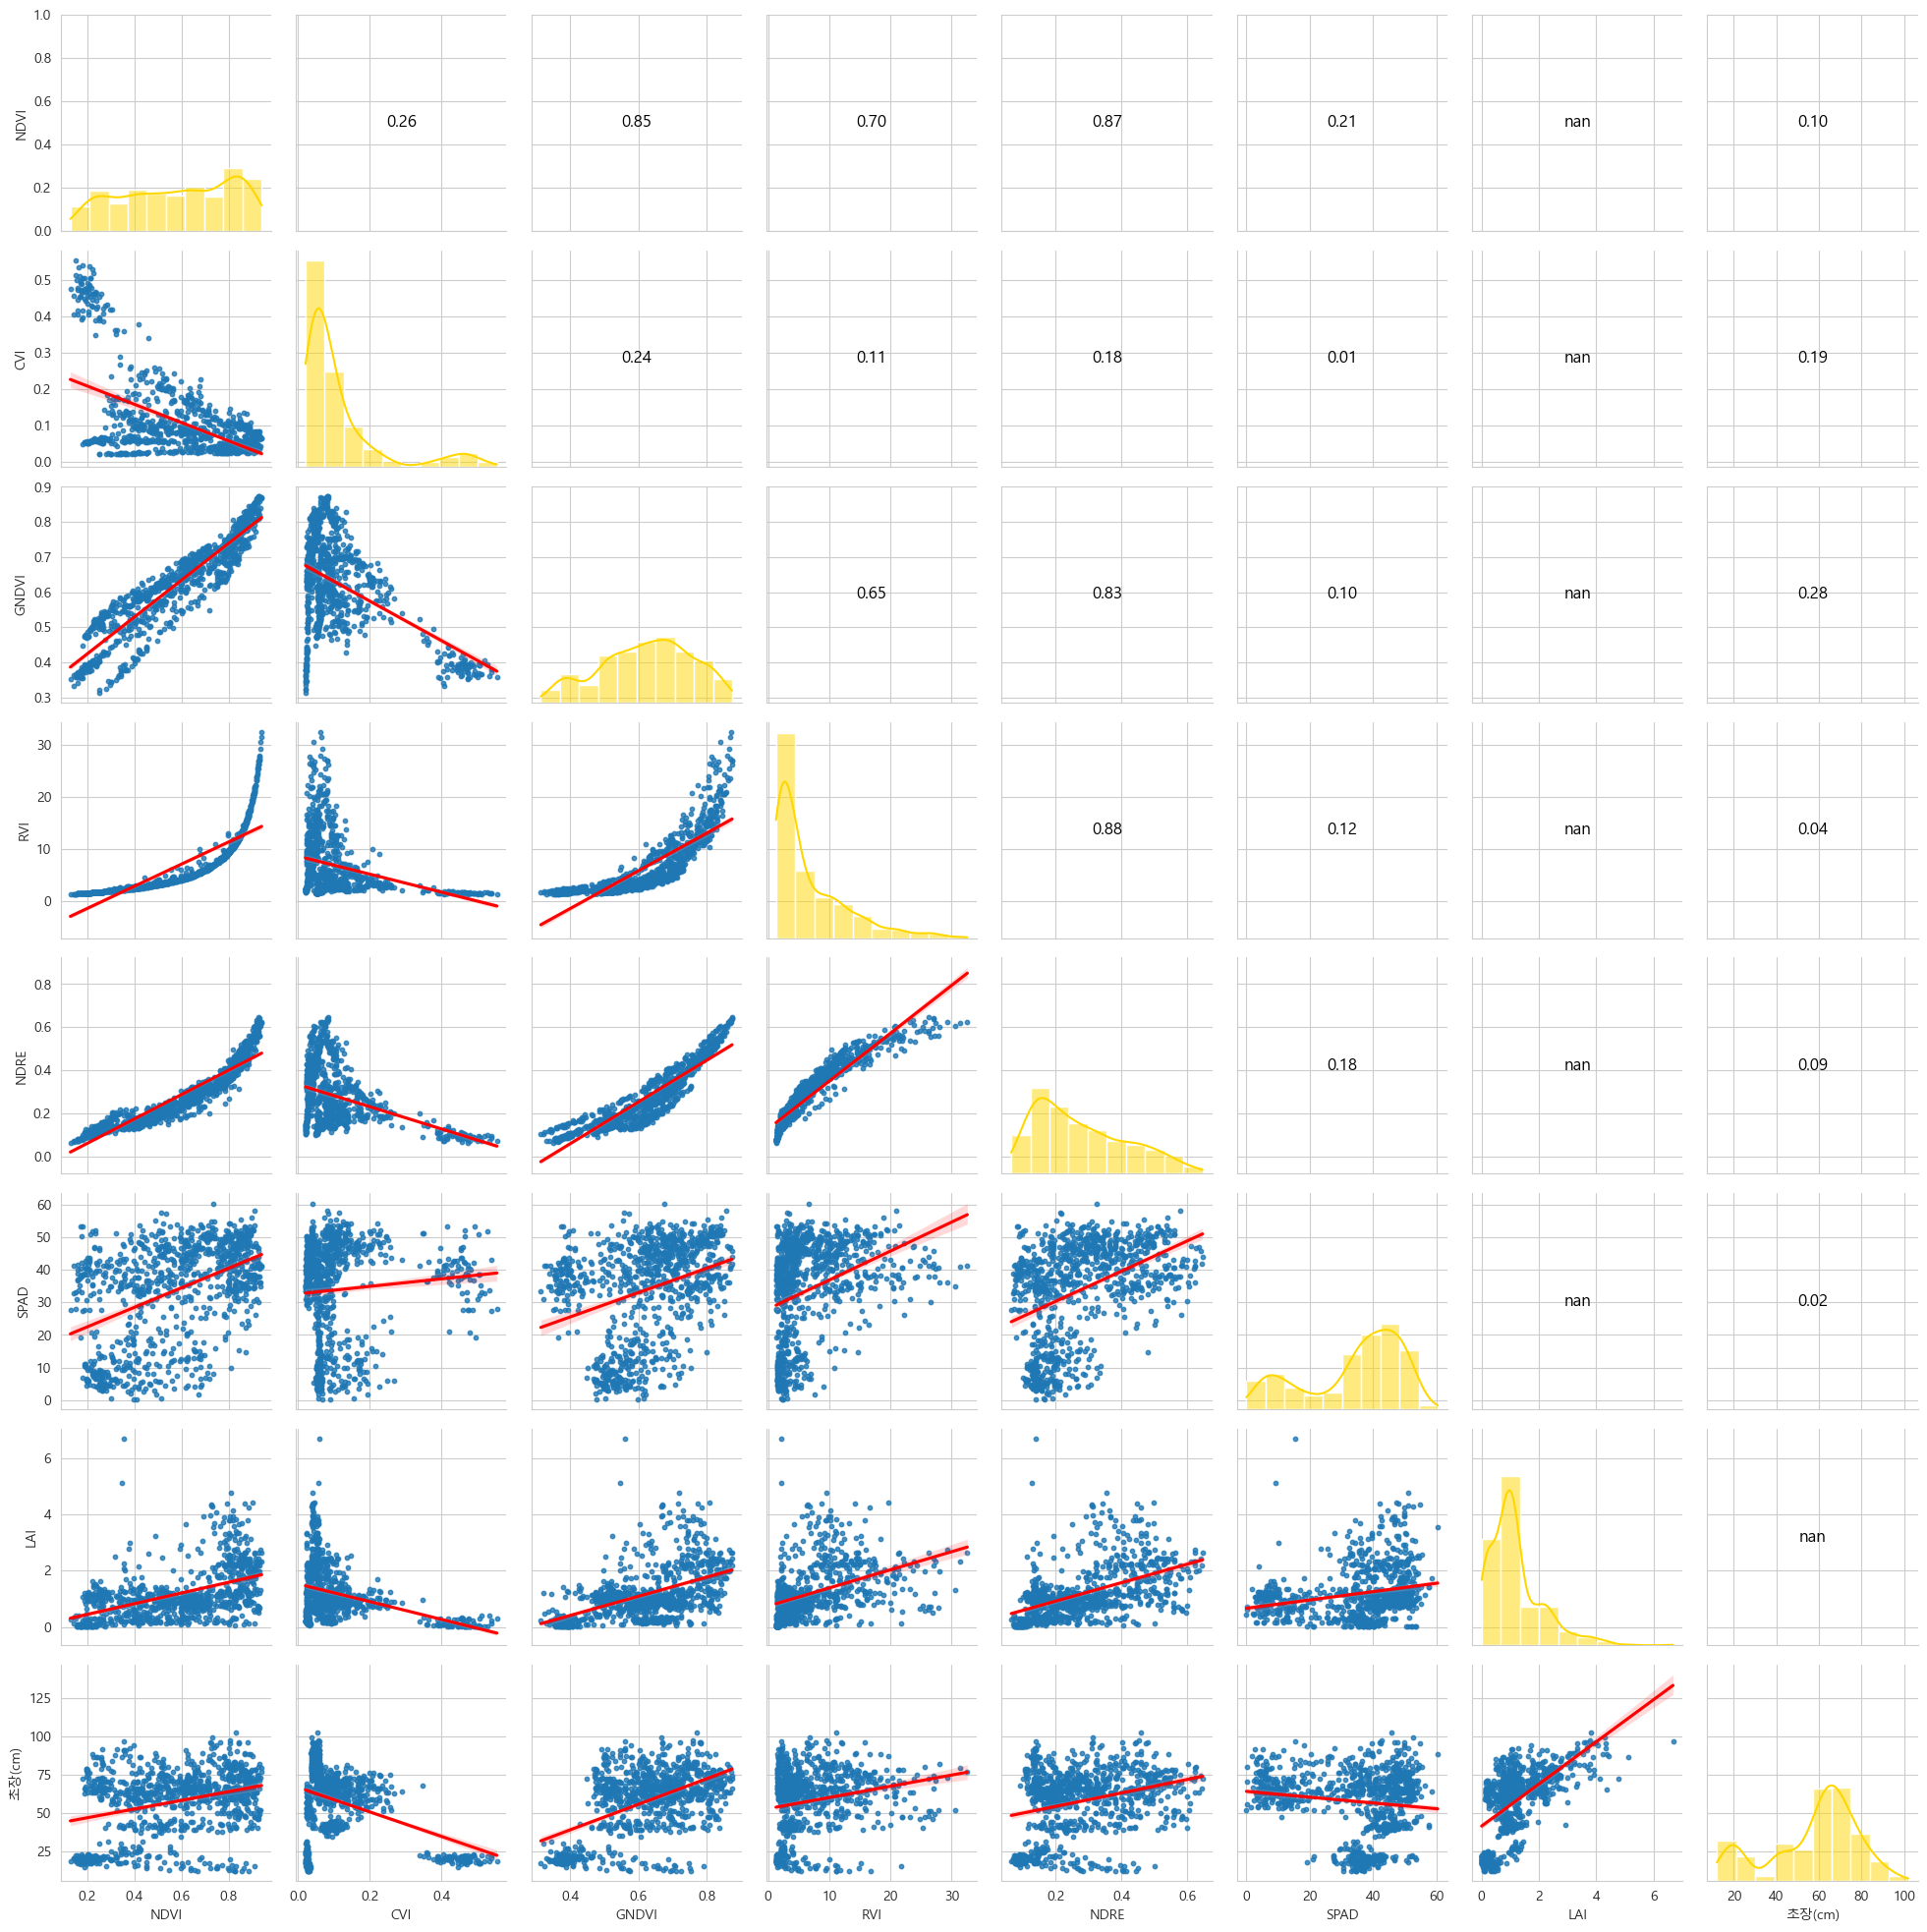

In [157]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def calculate_r2(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value ** 2


def upper_r2(x, y, **kwargs):
    r2 = calculate_r2(x, y)
    ax = plt.gca()
    ax.annotate(f'{r2:.2f}', xy=(0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center', fontsize=12, color='black')


def lower_scatter_with_reg(x, y, **kwargs):
    ax = plt.gca()
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'s': 10}, line_kws={"color": "red"})


def corrfunc(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    plt.gca().annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords="axes fraction",
                       ha="center", va="center", fontsize=12)


def lower_scatter_with_reg2(x, y, **kwargs):
    ax = plt.gca()
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'s': 10}, line_kws={"color": "red"})


def pair_plot(data):
    # combine_info = {
    #     "": ["TMX", "TMN", "SRAD", "WSPD", "RHUM", "PRCP"],
    #     "Rainfall Days": ["r20", "r30", "r50", "r80", "PRCP"],
    #     "Total Rainfall": ["r20_sum", "r30_sum", "r50_sum", "r80_sum", "PRCP"]
    # }
    values = ['NDVI', 'CVI', 'GNDVI', 'RVI', 'NDRE', 'SPAD', 'LAI', '초장(cm)']
    # for key, values in combine_info.items():
    df = data[values]
    g = sns.PairGrid(df, vars=values)
    g.map_upper(upper_r2)
    g.map_lower(lower_scatter_with_reg)
    g.map_diag(sns.histplot, kde=True, color="gold", bins=10)
    plt.show()
    
        # r2_save_path = os.path.join(save_folder, f"r2_{key}.png")
        # plt.savefig(r2_save_path)
        # print("Save:", r2_save_path)
    
    
pair_plot(df)

In [17]:


y_variables = ['초장(cm)', 'LAI', 'SPAD', 'NDVI', 'GNDVI', 'RVI', 'CVI', 'NDRE'] 

df_mean = df.groupby(['year', '생육단계', '시비'])[y_variables].mean().reset_index()


from pandas.api.types import CategoricalDtype
df_mean['생육단계'] = df_mean['생육단계'].astype(CategoricalDtype(categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'], ordered=True))
df_mean

,year,생육단계,시비,초장(cm),LAI,SPAD,NDVI,GNDVI,RVI,CVI,NDRE
0,2023,개화기,기비,63.6250,1.026000,49.1250,0.672329,0.703689,8.067494,0.153582,0.335754
1,2023,개화기,추비,62.2250,1.000500,50.0225,0.683575,0.714639,7.907832,0.148093,0.349525
2,2023,개화후2주,기비,70.4000,1.411750,47.3850,0.704870,0.711188,7.489133,0.128793,0.333588
3,2023,개화후2주,추비,70.0000,1.458000,48.0725,0.711710,0.725039,8.187030,0.148940,0.364150
4,2023,개화후4주,기비,62.8625,0.344250,21.1075,0.548565,0.641020,3.825845,0.089016,0.184626
5,2023,개화후4주,추비,64.4325,0.438500,31.8500,0.612809,0.675043,5.031419,0.086387,0.230905
6,2023,분얼전기,기비,20.2875,0.143000,39.0625,0.221028,0.395576,1.609895,0.445952,0.100922
7,2023,분얼전기,추비,19.7825,0.104500,38.5125,0.213536,0.391512,1.579824,0.454649,0.097270
8,2023,분얼후기,기비,41.0625,1.020750,45.4750,0.565269,0.601063,4.749899,0.091399,0.255851
9,2023,분얼후기,추비,40.9250,1.101000,45.7450,0.549044,0.594443,4.369041,0.098849,0.251639


In [19]:
growth_stages = ['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기']
df_mean['생육단계'] = pd.Categorical(df_mean['생육단계'], categories=growth_stages, ordered=True)

# 데이터 정렬
df_mean = df_mean.sort_values('생육단계')

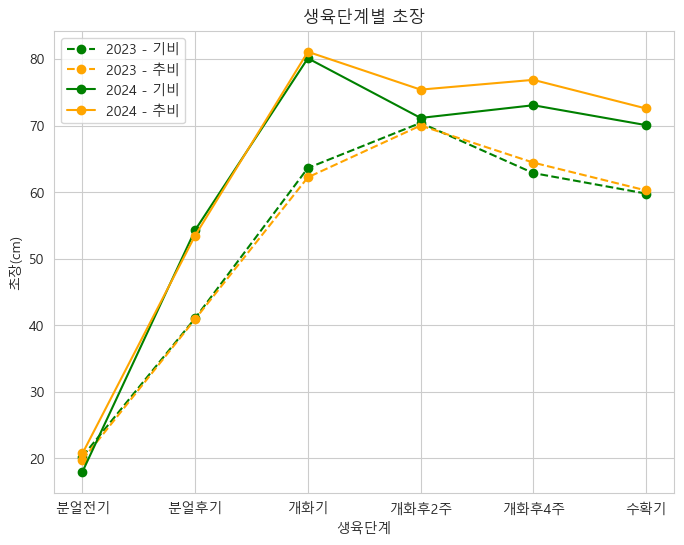

In [20]:
colors = {'기비': 'green', '추비': 'orange'}
linestyles = {2023: '--', 2024: '-'}

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 6))

for (year, 시비), group in df_mean.groupby(['year', '시비']):
    
    # group['생육단계'] = group['생육단계'].astype(CategoricalDtype(categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'], ordered=True))

    ax.plot(
        group['생육단계'],
        group['초장(cm)'],  # 'LAI'로 변경하려면 여기를 수정하세요.
        label=f'{year} - {시비}',
        color=colors[시비],
        linestyle=linestyles[year],
        marker='o'  # 각 지점을 강조하려면 추가
    )

ax.set_xlabel('생육단계')
ax.set_ylabel('초장(cm)')
ax.set_title('생육단계별 초장')
ax.legend()
plt.show()